Binary logit

In [11]:
import pandas as pd
import numpy as np
import polars as pl
import os
from sklearn.metrics import confusion_matrix as cm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss


In [13]:
file_path = os.path.join(os.getcwd(), 'input for binary logit.xlsx')

df = pd.read_excel(file_path, sheet_name="input")


train_on_B = pd.read_excel(file_path, sheet_name="foldB")
test_A = pd.read_excel(file_path, sheet_name="foldA")

train_on_A= pd.read_excel(file_path, sheet_name="foldA")
test_B = pd.read_excel(file_path, sheet_name="foldB")

In [14]:
train_on_B.columns.astype(str)
test_A.columns.astype(str)
train_on_A.columns.astype(str)
test_B.columns.astype(str)

Index(['PurchaseDecision', 'id', 'panelist', 'AnyDisp', 'AnyFeat', 'AvgPrice',
       'LastUnitsPPWeek', 'hhInc', '14101667', '14101758',
       ...
       '14813048', '14813055', '14814137', '14814525', '14814913', '14815837',
       '14817429', '14817643', '14818070', '14818252'],
      dtype='object', length=258)

Estimating the model

In [15]:

x = df.iloc[:, 3:]
x.columns = x.columns.astype(str)

y = df['PurchaseDecision']

x.columns.astype(str)


Index(['AnyDisp', 'AnyFeat', 'AvgPrice', 'LastUnitsPPWeek', 'hhInc',
       '14101667', '14101758', '14102087', '14102160', '14102335',
       ...
       '14813048', '14813055', '14814137', '14814525', '14814913', '14815837',
       '14817429', '14817643', '14818070', '14818252'],
      dtype='object', length=255)

In [24]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# Add a constant (intercept) to the model
x = sm.add_constant(x)

# Fit the logistic regression model using statsmodels
logit_model = sm.Logit(y, x)
result = logit_model.fit()

# Get the coefficients, p-values, and other statistics
coefficients = result.params
p_values = result.pvalues
log_likelihood = result.llf
t_values = result.tvalues


# Create a DataFrame to display the results
results_df = pd.DataFrame({
    'Feature': coefficients.index,
    'Coefficient': coefficients.values,
    'P-value': p_values.values,
    'T-statistic': t_values.values
})

print("Log Likelihood:", log_likelihood)

print(results_df.head(20))

Optimization terminated successfully.
         Current function value: 0.325692
         Iterations 10
Log Likelihood: -12702.965961522157
            Feature  Coefficient       P-value   T-statistic
0             const    -1.601920  9.999984e-01 -1.954970e-06
1           AnyDisp     0.096726  7.255736e-03  2.684873e+00
2           AnyFeat     0.058105  9.074414e-02  1.691485e+00
3          AvgPrice    -5.453631  7.756298e-03 -2.662498e+00
4   LastUnitsPPWeek    -0.415028  6.255988e-24 -1.008779e+01
5             hhInc     0.111011  9.999990e-01  1.232969e-06
6          14101667    -1.100056  9.999992e-01 -9.408772e-07
7          14101758    -1.305826  9.999992e-01 -9.452912e-07
8          14102087    -1.840099  9.999983e-01 -2.165336e-06
9          14102160    -0.919247  9.999993e-01 -8.325948e-07
10         14102335     0.886896  9.999995e-01  6.089617e-07
11         14103499    -2.286965  9.999987e-01 -1.570278e-06
12         14103580     2.028131  9.999989e-01  1.392557e-06
13     

In [28]:
#calculate McFadden R2

log_likelihood_fitted = result.llf

null_model = sm.Logit(y, np.ones((x.shape[0], 1))).fit(disp=0)
log_likelihood_null = null_model.llf

mcfadden_r2 = 1 - (log_likelihood_fitted / log_likelihood_null)

print( mcfadden_r2)

0.19048305713739688


Forecasting


In [19]:
#We have model 1 and model 2
#Model 1: trained on A and used to predict B (pred1 is prediction of model1)

model_1 = LogisticRegression()

#training data of model1 is train_x1, this is the expl vars from Fold A
train_x1 = train_on_A.iloc[:, 3:]
train_y1 = train_on_A['PurchaseDecision']

# Convert column names to strings
train_x1.columns = train_x1.columns.astype(str)

#Model 1 predicts fold B, so our test set is fold B

# Convert test_B column names to strings
test_B.columns = test_B.columns.astype(str)

# Ensure test_B only contains columns present in train_x1 and train_x2
test_B_filtered = test_B[train_x1.columns]

# Train model_1 on fold A
model_1.fit(train_x1, train_y1)

# Predict on test_B using model_1
pred_1 = model_1.predict(test_B_filtered)

# Print the classification report for predictions on test_B
print(classification_report(test_B['PurchaseDecision'], pred_1, digits=4))


              precision    recall  f1-score   support

           0     0.9332    0.9866    0.9592     16813
           1     0.8740    0.5680    0.6886      2748

    accuracy                         0.9278     19561
   macro avg     0.9036    0.7773    0.8239     19561
weighted avg     0.9249    0.9278    0.9212     19561



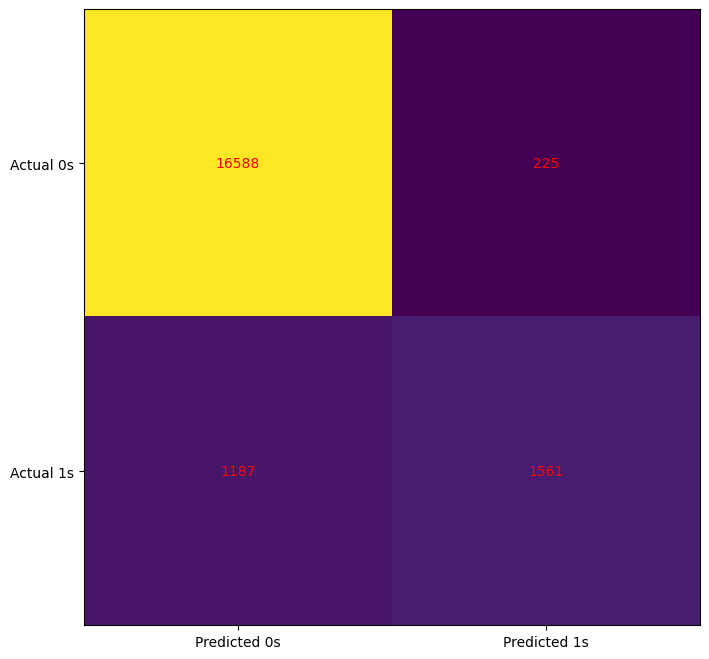

In [20]:
true_1 = test_B["PurchaseDecision"] 
confusion_matr = cm(true_1, pred_1)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(confusion_matr)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, confusion_matr[i, j], ha='center', va='center', color='red')
plt.show()


In [21]:
#Model 2: trained on B and used to predict A (pred2 is prediction of model2)
model_2 = LogisticRegression()

#training data of model2 is train_x2, this is the expl vars from Fold B
train_x2 = train_on_B.iloc[:, 3:]
train_y2 = train_on_B['PurchaseDecision']

train_x2.columns = train_x2.columns.astype(str)


test_A.columns = test_A.columns.astype(str)

test_A_filtered = test_A[train_x2.columns]

model_2.fit(train_x2, train_y2)

pred_2 = model_2.predict(test_A_filtered)

print(classification_report(test_A['PurchaseDecision'], pred_2, digits=4))


              precision    recall  f1-score   support

           0     0.9369    0.9872    0.9614     16786
           1     0.8775    0.5798    0.6983      2656

    accuracy                         0.9315     19442
   macro avg     0.9072    0.7835    0.8298     19442
weighted avg     0.9288    0.9315    0.9254     19442



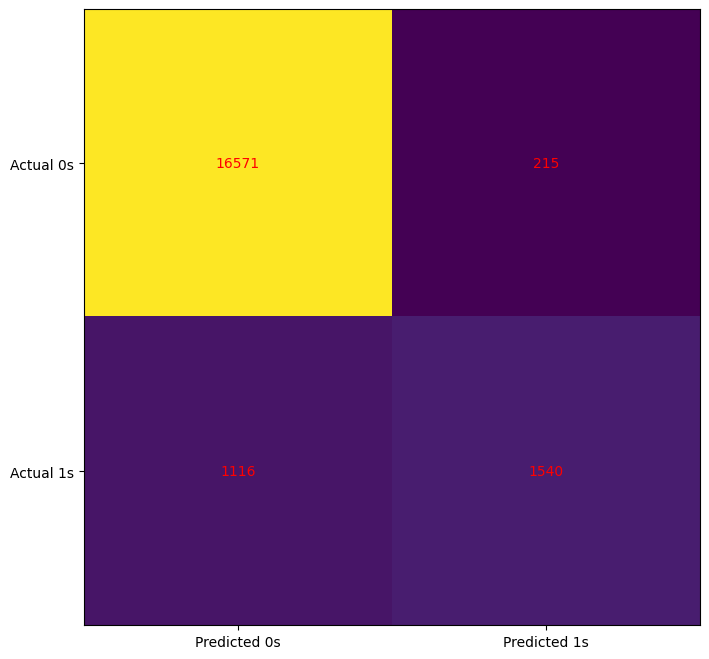

In [22]:
true_2 = test_A["PurchaseDecision"] 
confusion_matr = cm(true_2, pred_2)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(confusion_matr)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, confusion_matr[i, j], ha='center', va='center', color='red')
plt.show()
